**Collaborator for this notebook**

**Collaborator 1: Anamika Jha 
Kaggle ID: anamikajha**

**Collaborator 2: Pratishtha Kapoor
Kaggle ID: Pratishtha**

**We woluld like to thank Affine Analytics for all there support and guidance provided in the completion of this chllenge**

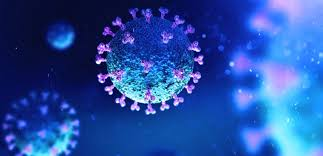

# What do we know about COVID-19 risk factors?

## COVID-19 Open Research Dataset Challenge (CORD-19)


### Task Details

What do we know about COVID-19 risk factors? What have we learned from epidemiological studies?

Specifically, we want to know what the literature reports about:


	
1. Data on potential risks factors
		
    * Smoking, pre-existing pulmonary disease
    * 		Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities
    * 		Neonates and pregnant women
    * 		Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.
	
	
2. Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors
    * 	Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups
    * 	Susceptibility of populations
    * Public health mitigation measures that could be effective for control


#### Pros
*Word2Vec has several advantages over bag of words and IF-IDF scheme. Word2Vec retains the semantic meaning of different words in a document. The context information is not lost. Another great advantage of Word2Vec approach is that the size of the embedding vector is very small. Each dimension in the embedding vector contains information about one aspect of the word. We do not need huge sparse vectors, unlike the bag of words and TF-IDF approaches.*

#### Cons
*We still need to create a huge sparse matrix, which also takes a lot more computation than the simple bag of words approach*

#### Approach
Our approach has been to perfom a text analysis from the meta data file provided and identify the most important topics from the text and map all the json files or documents related with that topic 
For example if we have a document in the meta file if identify the dominant topic that contribute highest in the document detection and relate it to all the json files that fall inline with that topic

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re

import nltk
import spacy
#from glove import Corpus, Glove
#from gensim.utils import deaccen
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
##Importing necessary files 
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import time
import re
from sklearn.decomposition import PCA
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import string
import gensim
from sklearn.manifold import TSNE
from gensim.test.utils import get_tmpfile
from gensim.models import Word2Vec, FastText
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import nltk
#nltk.download('stopwords')
import gensim

from nltk.corpus import stopwords 

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

In [ ]:
stop_words = stopwords.words('english')

In [ ]:
meta_df = pd.read_csv('/kaggle/input/CORD-19-research-challenge/metadata.csv', usecols=['cord_uid', 'sha', 'title', 'doi', 'abstract', 
                                                 'authors', 'publish_time','Microsoft Academic Paper ID','pubmed_id',
                                              'has_pdf_parse', 'has_pmc_xml_parse'], dtype={'pubmed_id': str,
                                                                                           "Microsoft Academic Paper ID":str})

In [ ]:
meta_df.abstract.isnull().sum()

In [ ]:
meta_df_cp = meta_df.copy()

meta_df_cp = meta_df_cp[pd.notnull(meta_df_cp.abstract)]

### Tokenize the words and clean the abstract read from the metacsv file

#### Gensim simple_preporcess method is being used to tokenize and clean data by removing stopwords and punctuation if any found in the abstract

In [ ]:
def sentence_clean(tokens):
    for token in tokens:
        yield(gensim.utils.simple_preprocess(str(token), deacc=True))

datatokens = list(sentence_clean(meta_df_cp.abstract.values.tolist()))

In [ ]:
def review_preprocess(review):
    
    en_stops = set(stopwords.words('english'))
    
    ##Removing any tags
    
    clean = re.compile('<.*?>')
    review_without_tag = re.sub(clean, '', review) 
    
    ###Remove any unwanted url
    
    review_without_tag_and_url = re.sub(r"http\S+", "", review_without_tag)
    review_without_tag_and_url = re.sub(r"www\S+", "", review_without_tag)
    
    ##Convert to lower case
    
    review_lowercase = review_without_tag_and_url.lower()
    
    ##split into words
    
    list_of_words = word_tokenize(review_lowercase)
    
    ##Remove punctuation

    list_of_words_without_punctuation=[''.join(this_char for this_char in this_string if (this_char in string.ascii_lowercase))for this_string in list_of_words]
     
    ## Remove any empty string
    
    list_of_words_without_punctuation = list(filter(None, list_of_words_without_punctuation))
    
    ###Remove any stop words

    filtered_word_list = [w for w in list_of_words_without_punctuation if w not in en_stops] 
    
    ### join all cleaned data
    return ' '.join(filtered_word_list)

In [ ]:
meta_df_cp.tail()

In [ ]:
import time
start_time=time.time()
meta_df_cp['new']=meta_df_cp['abstract'].apply(review_preprocess)
print('Elapsed time for review preprocessing : ',((time.time()-start_time)/60),' in minutes')

In [ ]:
meta_df_cp['new'].tail()

In [ ]:
data = meta_df_cp.new.str.cat(sep=' ')

###tokenize words
tokens = word_tokenize(data)

vocabulary = set(tokens)
print('Number of vocabulary : {}'.format(len(vocabulary)))

##frequency distribution of words
frequency_distribution = nltk.FreqDist(tokens)
sorted(frequency_distribution,key=frequency_distribution.__getitem__, reverse=True)[0:5]

In [ ]:
###plotting wordcloud from frequency distribution
wordcloud = WordCloud().generate_from_frequencies(frequency_distribution)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
###calculating words vs frequency distribution 
words_frequency= pd.Series(tokens).value_counts().reset_index()
words_frequency.columns = ['Word','Frequency']


words_frequency.head()

In [ ]:
### Bar plot of frequency distribution
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(17,9)})
### Fill the required inputs in the below code ###
ax = sns.barplot(x="Word", y="Frequency", data=words_frequency[words_frequency.index<20])

plt.show()

In [ ]:
### appending in list for word2vec
list_of_tokenized = []
for one_sentence in meta_df_cp.new:
    list_of_tokenized.append(gensim.utils.simple_preprocess(one_sentence))
    

In [ ]:
### usning word2vec model 
model = Word2Vec(list_of_tokenized, size=150, window=10, min_count=2, workers=10)

In [ ]:
list_of_tokenized[0]

In [ ]:
w1 = "population"
model.wv.most_similar(positive=w1)

In [ ]:
w1 = ["respiratory"]
model.wv.most_similar (positive=w1,topn=3)

In [ ]:
model.wv.doesnt_match(["china","coronavirus","pandemic","table"])

In [ ]:
###using pca and t-sne to plot the word embedding space
def word_vectors_plot(model, input_word, word_list):
    
    word_arrays = np.empty((0, 150), dtype='f')
    word_tags = [input_word]
    color_list  = ['blue']

    
    word_arrays = np.append(word_arrays, model.wv.__getitem__([input_word]), axis=0)
    
    
    similar_words = model.wv.most_similar([input_word],topn=8)
    

    for word_score in similar_words:
        word_vector = model.wv.__getitem__([word_score[0]])
        word_tags.append(word_score[0])
        color_list.append('green')
        word_arrays = np.append(word_arrays, word_vector, axis=0)
    
   
    for word in word_list:
        word_vector = model.wv.__getitem__([word])
        word_tags.append(word)
        color_list.append('red')
        word_arrays = np.append(word_arrays, word_vector, axis=0)
        
    
    reduce = PCA(n_components=17).fit_transform(word_arrays)
    
    
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduce)
    
    
    
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_tags,
                       'color': color_list})
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    
    
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE viz for input: {}'.format(input_word.title()),fontsize=16)

In [ ]:
word_vectors_plot(model, 'coronavirus', ['china', 'infection', 'ncov', 'respiratory', 'covid', 'transmission', 'wuhan', 'severe'])

In [ ]:
bigram = gensim.models.Phrases(datatokens, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

def remove_stopwords(words):
    return [[word for word in simple_preprocess(str(row)) if word not in stop_words] for row in words]

def lemmatize_text(words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    text = []
    for sent in words:
        row = nlp(" ".join(sent)) 
        text.append([token.lemma_ for token in row if token.pos_ in allowed_postags])
    return text

def create_bigram(text):
     return [bigram_mod[doc] for doc in text]

In [ ]:
data_word = remove_stopwords(datatokens)

data_word = create_bigram(data_word)

In [ ]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

lemmatized_text = lemmatize_text(data_word, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
lemmatized_text[:1]

In [ ]:
data_word[0]

 ****Create a Dictionary and corpus which is required for topic modeliing****
 The main inpyts for topic modelling is the dictionary and the corpu 

In [ ]:
# Create the dictionary all the tokens or words we have preprocessed using the above data 

id2word = corpora.Dictionary(lemmatized_text)

# create a corpus 
corpus = [id2word.doc2bow(text) for text in lemmatized_text]

In [ ]:
[[(id2word[id], freq) for id, freq in corp]for corp in corpus[:1]]

*In the next step we are going to identiy the optimal number of topics this is computed using coherence value*

In [ ]:
def compute_coherence(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    """
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence(dictionary=id2word, corpus=corpus, texts=lemmatized_text, start=2, limit=40, step=6)

In [ ]:
# TF-IDF Document Frequency
tfidf = TfidfModel(corpus)
tfidf_corpus = tfidf[corpus]

In [ ]:
# Show graph
limit=40; start=2; step=6#
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# # Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

LDA

In [ ]:
import collections
 
try:
    from collections import OrderedDict
except ImportError:
    OrderedDict = dict

In [ ]:
data_lda = {i: OrderedDict(optimal_model.show_topics(i,5)) for i in range(5)}


In [ ]:
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

In [ ]:
# g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
# plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
# plt.show()
#plt.setp(ax_heatmap.get_yticklabels(), rotation=0)  # For y axis

> ***Identify the dominat topic for all the senetences we have in our dataset from the optimal LDA created ***

In [ ]:
def dominat_topic_ident(ldamodel, corpus, text):
    # output
    dominat_topic_sent = pd.DataFrame()
    
    # get the dominat topic for all the sentences in the dataset
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x : (x[1]), reverse=True)
        # Get the dominat topic, it's percentage contribution and Keywords for each document 
        for j, (topic_num, prop_topic) in enumerate (row):
            # dominat topic 
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([w for w, p in wp])
                dominat_topic_sent = dominat_topic_sent.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), 
                                                          ignore_index=True)
            else:
                break
    dominat_topic_sent.columns = ['Domiant_topic', 'Percentage_contribution', 'Keywords']
    
    # Add original text to the end of the output
    contents = pd.Series(text)
    dominat_topic_sent = pd.concat([dominat_topic_sent, contents], axis=1)
    return(dominat_topic_sent)

In [ ]:
df_topic_sents_keywords = dominat_topic_ident(ldamodel=optimal_model, corpus=corpus, text=meta_df_cp.abstract.values.tolist())

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Percentage_Contrib', 'Keywords', 'Text']

In [ ]:
# Show
df_dominant_topic.head(10)

In [ ]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=26, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

**Clustering of topics **

In [ ]:
import matplotlib.colors as mcolors
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 26
mycolors = np.array([color for name, color in mcolors.XKCD_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

In [ ]:
def prediction_unseen_doc(lda_model, doc, threshold=0.1):
    """
    Get the most representative topic of a new documment
    """
    doc_preprocessed = doc.split()
    doc_tokens = bigram_mod[doc_preprocessed]
    bow_tokens = id2word.doc2bow(doc_tokens)

    rows = []
    for i, score in sorted(
        lda_model.get_document_topics(bow_tokens), key=lambda x: x[1], reverse=True
    ):
        if score > threshold:
            words, _ = zip(*lda_model.show_topic(i))
            rows.append([f"Topic_{i+1}", score, "; ".join(words)])
            break

    return pd.DataFrame(rows, columns=["Topic", "Score", "Words"])

In [ ]:
def document_same_topic(df_topic, df_dominant_topic, df_merged):
    """
    Obtain documents that have the same topic as df_topic
    """

    for index, row in df_topic.iterrows():
        topic = int(row["Topic"].split("_")[-1])

        doc_same_topic = list(
            df_dominant_topic[df_dominant_topic["Dominant_Topic"] == topic][
                "Document_No"
            ]
        )

        doc_detail = df_merged.loc[doc_same_topic]

    return doc_detail

In [ ]:
QUERY1 = '''
Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors
'''
QUERY2 = '''
Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups
'''
QUERY3 = '''
Susceptibility of populations
         '''

In [ ]:
# Preprocess the queries
query_1_preprocessed = review_preprocess(QUERY1)
query_2_preprocessed = review_preprocess(QUERY2)
query_3_preprocessed = review_preprocess(QUERY3)


In [ ]:
unseen_doc_q1 = prediction_unseen_doc(lda_model=optimal_model,doc=query_1_preprocessed)
unseen_doc_same_topic_q1 = document_same_topic(unseen_doc_q1, df_dominant_topic, meta_df_cp).head(10)

In [ ]:
unseen_doc_q1.style.background_gradient(cmap='viridis')

In [ ]:
unseen_doc_same_topic_q1.head()

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary=optimal_model.id2word)
vis

3.5.1 Train a Glove model

In [ ]:
# Creating a corpus object
#corpus = Corpus()

In [ ]:
# Fit the corpus with a list of tokens
#corpus.fit(docs_tokens, window=10)